## Load the model from Hugging Face Hub:

In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-single-tf'

dataset_dir = '/scratch/pawsey0864/anicolson/datasets'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


## The images:

In [2]:
# Images from study of Patient 1:
image_1 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/4a5283d6-157b6054-3840ea3d-d27e7ba1-d6689022.jpg'))
image_1 = image_1.convert('RGB')

image_2 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/7794e4cb-719a0b85-18532575-0b5ea119-8eb26b6a.jpg'))
image_2 = image_2.convert('RGB')

# Images from study from Patient 2:
image_3 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15131736/s57531802/308bf948-d05f2a1d-2c32a818-2df09584-d17283f6.jpg'))
image_3 = image_3.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)

images = torch.stack([image_1, image_2, image_3], dim=0)
images.shape

torch.Size([3, 3, 384, 384])

### Images from all of the studies:

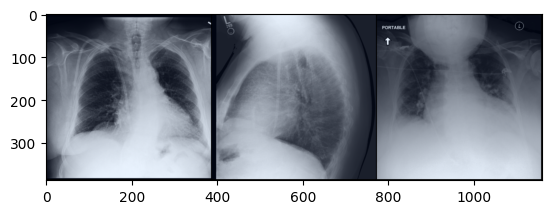

In [3]:
plt.imshow(make_grid(images, normalize=True).permute(1, 2, 0))

## Generate the reports:

In [4]:
outputs = encoder_decoder.generate(
    pixel_values=images,
    special_token_ids=[tokenizer.sep_token_id],
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=4,
)
outputs.sequences

tensor([[   1,  668,  148,  369,  546,  132,  115,  250,  854,   23,  324,  182,
         1197, 2643, 4275, 3991,  535,  739,  282,  115, 1490, 1756,  132,  115,
         1204,  820,   23,  213,  120,  163,  322,  284,   21,  171,   21,  214,
          211,   23,  139,  449,  278,  120,  237,   23, 1427,  542,  569,  150,
          721,   23,  198,  801,  541,  780,  115,  182,  615,  120,  269,   23,
            3,  159,  271,  916,  389,   23,    2,    4,    4,    4,    4],
        [   1,  846,  148,  369,  546,  132,  115,  250,  725,  792,   23, 1916,
         3976,  182,   22,  580,  732,  816,  535,  739,  125,  115,  182,  878,
           23,  198,  322,  284,   21,  183,  171,   21,  214,  362,  132,  211,
          120,  269,   23,  139,  375,  148,  356,  800,  150,  402,   23,    3,
          159,  271,  397,  389,   23,    2,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4],
        [   1, 1562, 1066,  385,  132,

## Decode using the tokenizer:

In [5]:
# Findings and impression sections (exclude previous impression section):
findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer,
)
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: PA and lateral views of the chest provided. A right IJ access double lumen catheter terminates at the expected location of the cavoatrial junction. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.
Impression: No acute intrathoracic process.

Findings: Frontal and lateral views of the chest were obtained. Large bore right-sided central venous catheter terminates in the right atrium. No focal consolidation, pleural effusion, or evidence of pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.
Impression: No acute cardiopulmonary process.

Findings: Single portable view of the chest is compared to previous exam from ___. Exam is limited secondary to portable technique and patient's body habitus. There is no large confluent consolidation or overt pulmonary edema. Cardiac silhouette is enlarged but stable in configurati